In [121]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy
from astropy.modeling import models, fitting
import pandas as pd

In [62]:
z2a = pd.read_csv('./resources/zprofile-2a.tsv', sep='\t', skiprows=6, header=None)
z2b = pd.read_csv('./resources/zprofile-2b.tsv', sep='\t', skiprows=6, header=None)
z2c = pd.read_csv('./resources/zprofile-2c.tsv', sep='\t', skiprows=6, header=None)

colnames = ['freq', 'intensity']
z2a.columns, z2a.name = colnames, '2a'
z2b.columns, z2b.name = colnames, '2b'
z2c.columns, z2c.name = colnames, '2c'

zprofs = [z2a, z2b, z2c]

In [118]:
g_init = models.Gaussian1D(amplitude=2e-4, mean=88.2, stddev=1.)
fit_g = fitting.LevMarLSQFitter()

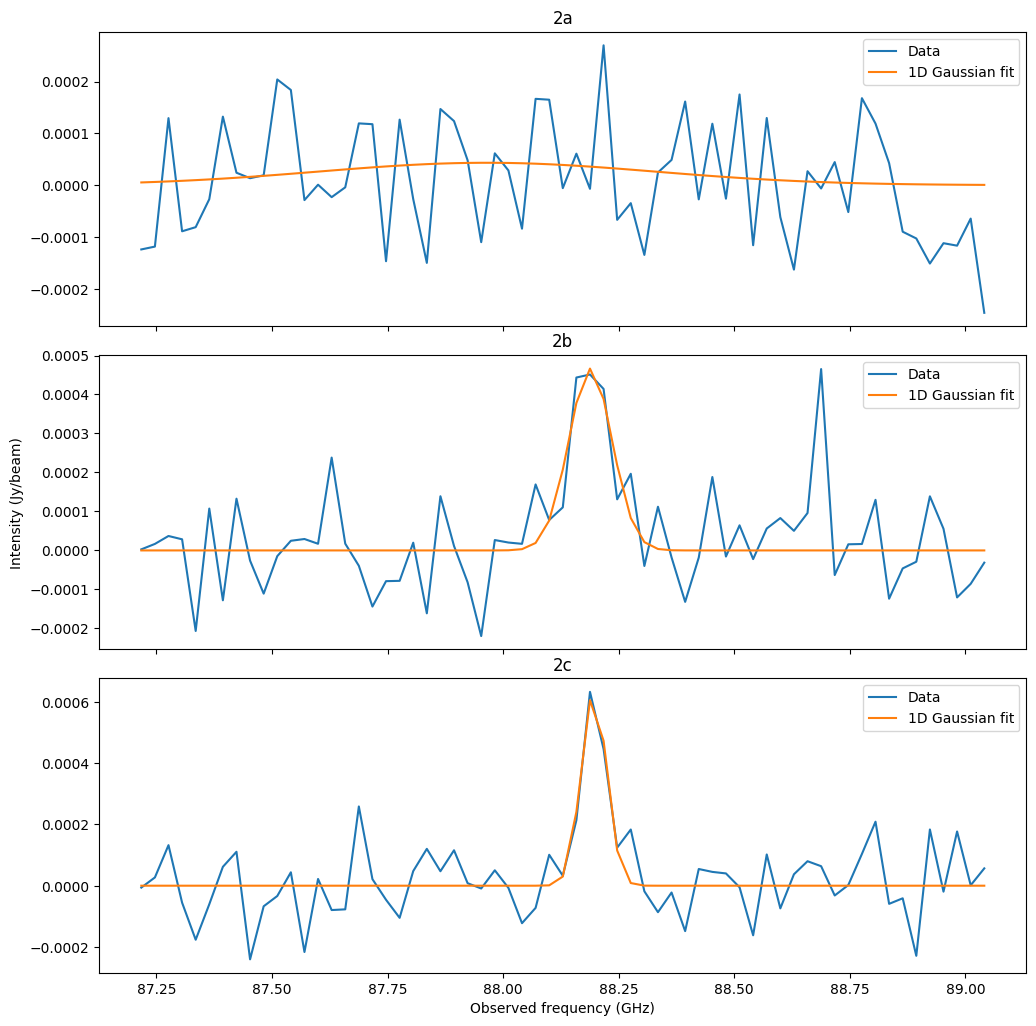

In [125]:
fig, ax = plt.subplots(3, figsize=(10, 10), dpi=100, sharex=True)
plt.tight_layout()
for i, j in enumerate(zprofs):
    g = fit_g(g_init, j.freq, j.intensity)
    ax[i].plot(j.freq, j.intensity, label='Data')
    ax[i].plot(j.freq, g(j.freq), label='1D Gaussian fit')
    ax[i].set_title(j.name)
    ax[i].legend()
    
ax[1].set_ylabel('Intensity (Jy/beam)')
ax[2].set_xlabel('Observed frequency (GHz)');

plt.savefig('gaussian_fit.png')